#  Characterization of novel enzymes from metagenomics data. 


## 1. Introduction

A number of novel sequences are found in metagenomics datasets. In this brief exercise, we will identify and farther analize novel enzymes belonging to the Glycyl Radical Enzyme superfamily using automated pipelines. GRE innovations have been recently reported to exist in gut microbiota, as reported in Levin et al. (2017).

http://science.sciencemag.org/content/355/6325/eaai8386.full



![GRE_paper](imgs/GRE_paper.png "GRE paper")

Levin et al. took microbial metagenome data and used a combination of bioinformatic tools to generate a network that clusters sequences of glycyl radical enzyme (GRE) superfamily and identify functional innovations. 

Experiments verified these homology and structural-chemical inferences. The analysis identified enzymes involved in anaerobic short-chain fatty acid production and L-proline biosynthesis, both of which are key mediators of healthy microbiota-host symbioses.



### 1.1 Distant GRE homologs found in human gut microbiota

<img src="imgs/GRE_network.png" style="width: 500px;"/>

(B) An SSN of the GRE superfamily (InterPro version 53.0; IPR004184, PFL domain) was constructed with an initial score of 10−300. The edge score was then refined such that nodes are connected by an edge if the pairwise sequence identity is ≥62% ID. Each of the 1843 nodes within the resulting SSN contains sequences with >95% amino acid identity. 

### 1.2 Multiple sequence alignment and active residues in reference GRE enzymes

<img src="imgs/GRE_bindings.png"  style="width: 700px;"/>

(A) Multiple sequence alignment of selected GREs. The regions shown contain residues that occupy the active sites of structurally characterized GREs and homology models of uncharacterized GREs. The residues at the positions marked with **asterisks** are conserved in different characterized GREs and **are known to play roles in substrate binding or catalysis**, making them useful for both identifying known GREs and revealing uncharacterized GREs with potentially distinct activities. Numbering corresponds to PD from R. inulinivorans (uncharacterized GRE cluster 16); accession numbers are from UniProt

## 2. DD-DeCaF enzyme discovery and characterization pipeline

### 2.1 Identify GRE superfamily members in metagenomics gene catalogs

For this exercise, GRE homologs have been pre-searched in several metagenomics datasets. Predicted unknown sequences are available in [GRE_metaG.faa](./GRE_metaG.faa). 


### 2.2 Annotate metaG sequences and find closest homologs using eggNOG-mapper

Upload [GRE_metaG.faa](./GRE_metaG.faa) to the online annotation tool [eggNOG-mapper](http://eggnogdb.embl.de/#/app/emapper?jobname=MM_kp096q). eggNOG-mapper will find the closest ortholog in the a global microbial reference database.  **For faster computation, choose HMMER mode and the Bacteria database**:

<img src="imgs/eggnog-mapper.png"  style="width: 500px;"/>

The annotation process using the online public service can take a while to finish. You can access the annotation results at http://eggnogdb.embl.de/#/app/emapper?jobname=MM_kp096q

For large scale studies, the local version of eggnog-mapper is recommended.

### 2.3 Explore annotations and fetch reference sequences from the eggNOG database

In [1]:
%%bash 
# Download eggnog-mapper annotations
wget http://eggnogdb.embl.de/MM_kp096q/GRE_metaG.faa.emapper.annotations -O GRE_metaG.faa.emapper.annotations 2> /dev/null

# Inspect content
cut -f1,2,5,10 GRE_metaG.faa.emapper.annotations|head -n5

SAMEA1906527-assembled_gene_186338	556261.HMPREF0240_01352	YBIW	05C6N|2.07291711938e-241|807.03326416
SAMEA1906527-assembled_gene_255688	556261.HMPREF0240_01352	YBIW	05C6N|8.93061292386e-247|824.801025391
SAMEA2042444-assembled_gene_41396	556261.HMPREF0240_01352	YBIW	05C6N|3.72409056079e-247|826.059936523
SAMEA1906527-assembled_gene_274020	888833.HMPREF9961_1053	YBIW	05C6N|2.65015630593e-306|1021.92633057
SAMEA1906527-assembled_gene_337003	445974.CLORAM_00910	YBIW	05C6N|3.88403336702e-302|1008.13098145


#### 2.3.1 Prepare sequences for phylogenetic analysis

In [2]:
%%bash
# download all eggnog sequences from the matching OG superfamily
wget http://eggnogapi.embl.de/nog_data/text/fasta/05C6N -O - 2>/dev/null | gunzip -c > GRE_eggnog_family.faa

# Extract the names of all reference sequences (seed orthologs in eggnog-mapper results)
cut -f2 GRE_metaG.faa.emapper.annotations|sort -u > GRE_ref_names.txt

# and extract the ones considered reference seqs in our analysis  
grep -f GRE_ref_names.txt -F -w GRE_eggnog_family.faa -A1|grep -v "\-\-" > GRE_ref_seqs.faa

head -n4 GRE_ref_seqs.faa

>1000570.HMPREF9966_1129
MPNVKEIEKTTIQTSYFGSLTDRMNKYREDVLDKKPYIDAERAVLATRAYQEHKEKPNVLKRAYMLKEILENMTLYIEDETMIVGNQASSNKDAPIFPEYTLEFVLNELDLFEKRDGDVFYITEETKEQIRSIAPFWENNNLRARAGALLPEEVQVYMETGFFGMEGKMNSGDAHLAVNYQKLLQYGLKGFEEKARAAKEALDLTDPASIDKYHFYDSIFIVVDAVKAYAERFVKLAQNMAESASPERRQELLEIARICSKVPYEPAETFAEAIQSVWFIQCILQIESNGHSLSYGRFDQYMYPYVKSDLEAGRETEESIVERLTNLWIKTITINKVRSQAHTFSSAGSPLYQNVTIGGQTRDKKDAVNPLSYLVLRSVAQTHLPQPNLTVRYHAGLDARFMNECIEVMKLGFGMPAFNNDEIIIPSFIAKGVLEEDAYDYSAIGCVETAVPGKWGYRCTGMSYMNFPKVLLITMNDGIDPASGKRFAPSFGHFKDMKSFAELQTAWDKTLRHLTRMSVIVENSIDLSLEREVPDILCSALTDDCIGRGKHLKEGGAVYDYISGLQVGIANLSDSLAAIKKLVFEEGKLTPAELWHALETDYAGERGKEIQEMLISDAPKYGNDDDYADKLVTDAYDIYVDEIAKYPNTRYGRGPIGGIRYSGTSSISANVGQGRGTLATPDGRNAGTPLAEGCSPSHNMDKNGPTSVLKSVSKLPTDEIVGGVLLNQKVNPQTLSKEEDKIKLIALLRTFFNRLHGYHIQYNVVSRETLIDAQKHPEKHRDLIVRVAGYSAFFNVLSKATQDDIIGRTEHTL
>160490.SPy_2049
MTETKSPYFGHLTDRMTHYREAVLDKKPYIDAERAILATEAYQKHQNKPANLKRAYMLQTILENMTIYIEDESLIAGNQASSNKDAPIFPEYTLEFVLNELDLFEKRDGDVFYITEETKQQLRDIAPFWENNNLRARCGVLLPE


### 2.3 Phylogenetic analysis 
Put all sequences (references and metagenomics) in the same FASTA file and run phylogenetic analysis on them.
For this, we will use the ETE toolkit, which provides both predefined phylogenetic reconstruction [workflows](  http://etetoolkit.org/documentation/ete-build/) and a [Python API](http://etetoolkit.org) to analyze the resulting trees. 

In [9]:
%%bash 
# Concatenate all sequences into a single fasta file
cat GRE_metaG.faa GRE_reference_seqs_from_paper.faa GRE_ref_seqs.faa > all_GRE_seqs.faa

# Count total sequences in fasta file
grep -c '>' all_GRE_seqs.faa

223


In [4]:
%%bash 
# Run phylogenetic reconstruction using ete3
ete3 build -w mafft_default-none-none-fasttree_default -a all_GRE_seqs.faa -o GRE_tree -t2 --clearall

Toolchain path: /Users/jhc/anaconda/bin/ete3_apps 
Toolchain version: 2.0.3

['mafft_default-none-none-fasttree_default']

      --------------------------------------------------------------------------------
                  ETE build (3.0.0b35) - reproducible phylogenetic workflows

      Citation:

       Huerta-Cepas J, Serra F and Bork P. ETE 3: Reconstruction, analysis and
       visualization of phylogenomic data. Mol Biol Evol (2016)
       doi:10.1093/molbev/msw046

      (Note that a list of the external programs used to complete all necessary
      computations will be shown after workflow execution. Those programs should
      also be cited.)

      --------------------------------------------------------------------------------
      
INFO -  Testing x86-64  portable applications...
       clustalo: OK - 1.2.1
Dialign-tx not supported in OS X
       fasttree: OK - FastTree Version 2.1.8 Double precision (No SSE3), OpenMP (1 threads)
         iqtree: OK - IQ-TREE multicor

### 2.4 Phylogenetic tree analysis using ETE toolkit

#### 2.4.1 Load tree as a Python object and bind nodes to sequences in the original multiple sequence alignment


In [5]:
from ete3 import PhyloTree
# Load tree and bind nodes to sequences in the original multiple sequence alignment
t = PhyloTree("GRE_tree/mafft_default-none-none-fasttree_default/all_GRE_seqs.faa.final_tree.nw")
t.link_to_alignment("GRE_tree/mafft_default-none-none-fasttree_default/all_GRE_seqs.faa.final_tree.fa")


#### 2.4.2 Locate active sites in reference sequences

In [6]:
# Find active sites based on GRE literature in a known reference sequence. 
# See alignment figure under 1.2
ref_seq =  (t & "Q1A666_9FIRM")
a = ref_seq.sequence.find('HVT')
b = ref_seq.sequence.find('HSI')
c = ref_seq.sequence.find('FQN')
d = ref_seq.sequence.find('CVE')
e = ref_seq.sequence.find('DAA')
f = ref_seq.sequence.find('YPV')
g = ref_seq.sequence.find('GYS')

# Collect active residues from all other sequences in the alignment
for leaf_node in t:  
    seq = ""
    for pos in (a,b,c,d,e,f,g):        
        seq += leaf_node.sequence[pos:pos+3]
        seq += '-'
    #print seq, x.name
    leaf_node.active_residues = seq



#### 2.4.3 Visualize phylogeny and active site variations

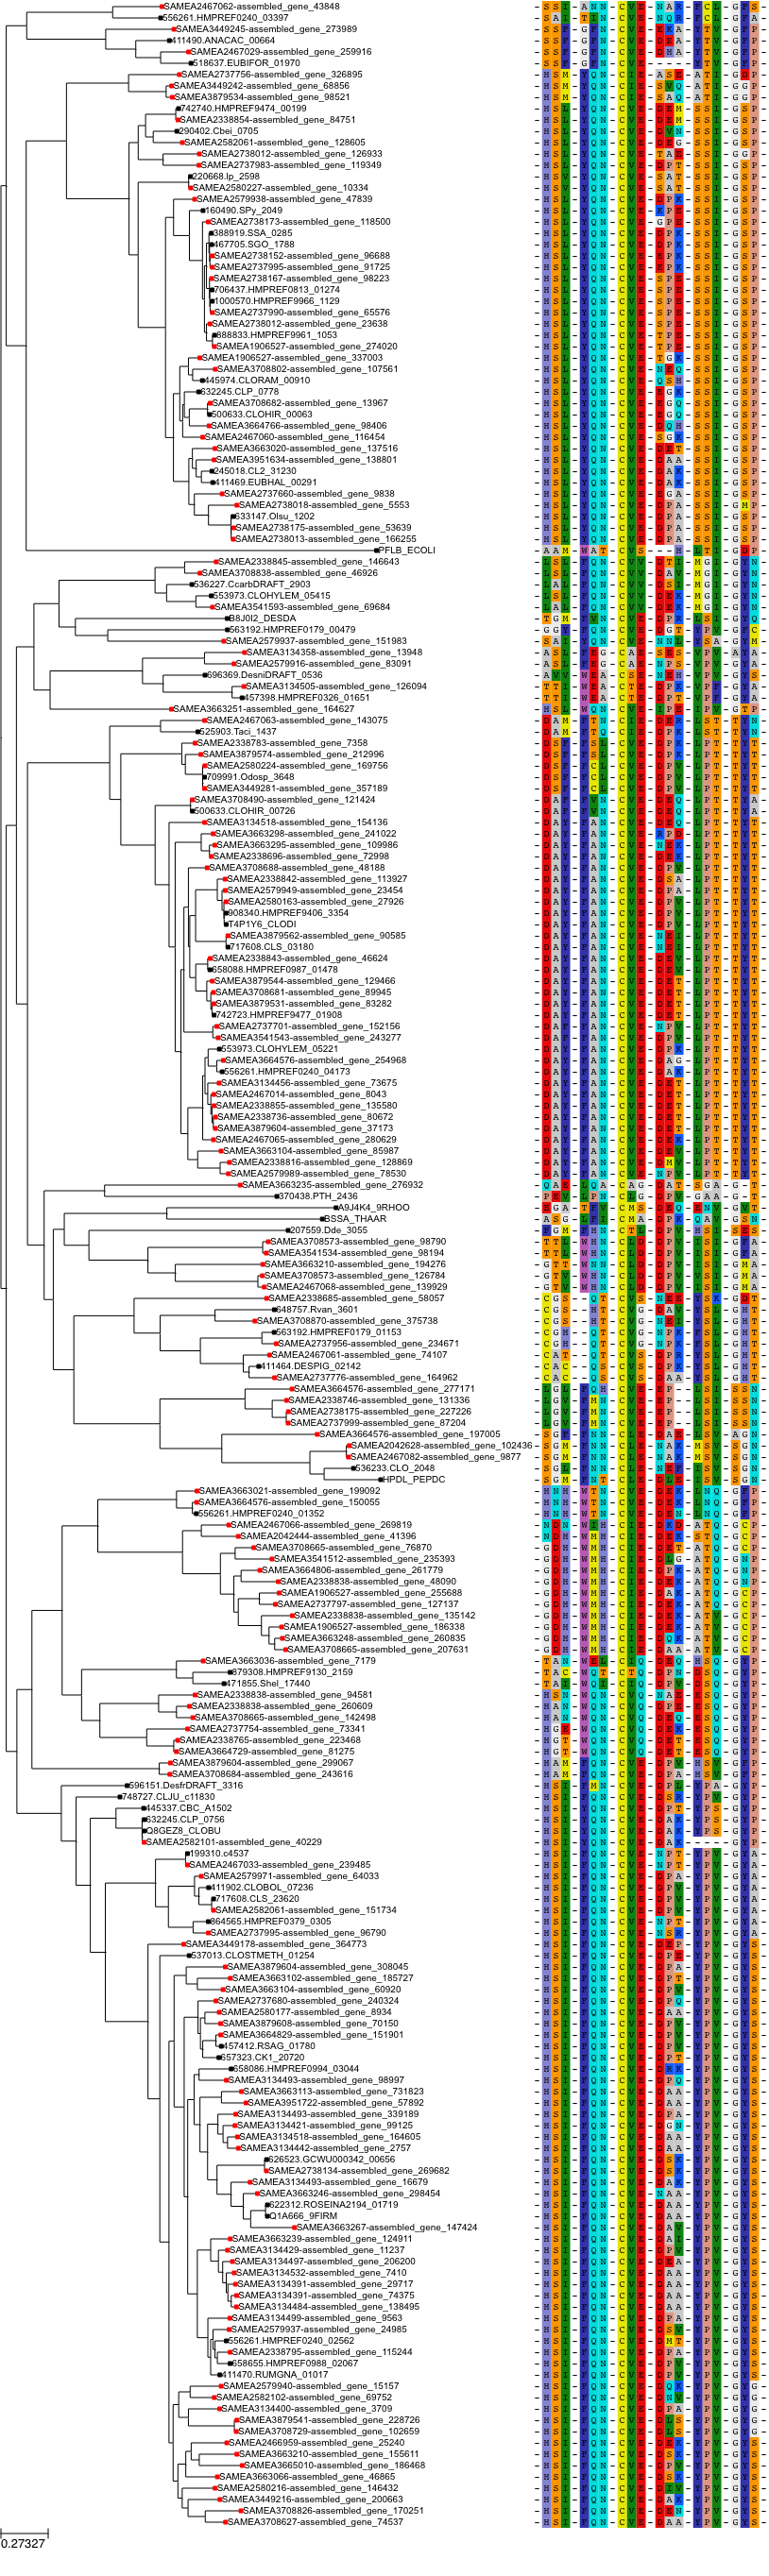

In [7]:
from ete3 import TreeStyle, SeqMotifFace, add_face_to_node

# Visualize phylogenetic distribution of active residues
def layout(node):
    node.img_style["size"] = 0
    if node.is_leaf():
        node.img_style["size"] = 4
        node.img_style["shape"] = "square"
        seq_img = SeqMotifFace(node.active_residues, seq_format="seq", height=12)
        add_face_to_node(seq_img, node, column=0, position='aligned')
        if "SAMEA" in node.name:             
            node.img_style["fgcolor"] = 'red'
        else:
            node.img_style["fgcolor"] = 'black'
        
ts = TreeStyle()
#ts.show_branch_support = True
ts.tree_width = 400
ts.layout_fn = layout    
t.render("%%inline", tree_style=ts)

# Index of tools

In [8]:
from IPython.display import HTML
HTML('<iframe src=imgs/tools.pdf width=900 height=350></iframe>')
